In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0, '../')
import pandas as pd
import tqdm
import pickle

import vis
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
### Configure file and folder names
data_h5 = "../data/paper/soccermix_all_data.h5"
models = "../data/paper/soccermix_models.pkl"

d_weights = "../data/paper/soccermix_all_dirweights.pkl"

spadl_h5 = "../data/tomd/spadl-statsbomb.h5"

In [3]:
X = pd.read_hdf(data_h5, "X")

In [4]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

items = loadall(models)
d_w = loadall(d_weights)

In [5]:
cat_model = next(items)
loc_models = next(items)
dir_models = next(items)

In [6]:
dir_weights = next(d_w)

In [7]:
games = pd.read_hdf(spadl_h5,"games")
games1819 = games[(games.competition_name == "Premier League")
               & (
                   (games.season_name == "2018/2019") 
                 )
             ]

In [8]:
pg = pd.read_hdf(spadl_h5,"player_games")
pg1819 = pg[pg.game_id.isin(games1819.game_id)]
mp = pg1819[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()
players = pd.read_hdf(spadl_h5, "players")

In [9]:
merged_weights = dir_weights.copy()
merged_weights["player_id"] = X.player_id.values
merged_weights["game_id"] = X.game_id.values

In [10]:
merged_weights = merged_weights[merged_weights.game_id.isin(games1819.game_id)]

In [11]:
vectors = {}

for p in tqdm.tqdm(list(mp.player_id.unique())):
    vec = merged_weights.loc[merged_weights.player_id == p, dir_weights.columns].sum().values
    vectors[int(p)] = vec

100%|██████████| 505/505 [01:03<00:00,  7.91it/s]


In [12]:
vectors_pd = pd.concat({k: pd.DataFrame(v).T for k,v in vectors.items()}).droplevel(level=1)
vectors_pd.index.name = "player_id"
vectors_pd.columns = dir_weights.columns

In [13]:
## Normalize vectors for minutes played

vectors_pd_norm = pd.merge(vectors_pd, mp, left_index=True, right_on='player_id').set_index('player_id')
vectors_pd_norm = vectors_pd_norm[vectors_pd_norm.minutes_played > 900]
df1 = vectors_pd_norm.loc[:, dir_weights.columns] * 90
vectors_pd_norm.loc[:, dir_weights.columns] = df1.divide(vectors_pd_norm.minutes_played, axis='rows')
vectors_pd_norm.drop(columns=['minutes_played'], inplace=True)

In [14]:
# Get positions for people with vectors if possible
positions = pd.read_hdf(spadl_h5, "player_games")
filled_in_positions = positions[positions.position_id != 0]

people_with_vector = vectors_pd_norm.index.values
people_with_position = filled_in_positions.player_id.unique()

people = set(people_with_position).intersection(set(people_with_vector))

In [15]:
players_ = list(people)
player_positions = pd.DataFrame(data={'player_id': players_}, columns=['player_id', 'position'])

for pl in players_:
    vc = filled_in_positions.loc[filled_in_positions.player_id == pl].position_name.value_counts()
    player_positions.loc[player_positions.player_id == pl, ['position']] = vc.index[0]

# Center Forward: Aguero - Firmino

In [16]:
print(players[players.player_name.str.contains('Sergio Leonel Agüero')].player_id)
print(players[players.player_name.str.contains('Firmino')].player_id)

131    3237
Name: player_id, dtype: int64
369    3535
Name: player_id, dtype: int64


In [17]:
print(player_positions[player_positions.player_id == 3237])
print(player_positions[player_positions.player_id == 3535])

     player_id        position
113       3237  Center Forward
     player_id        position
222       3535  Center Forward


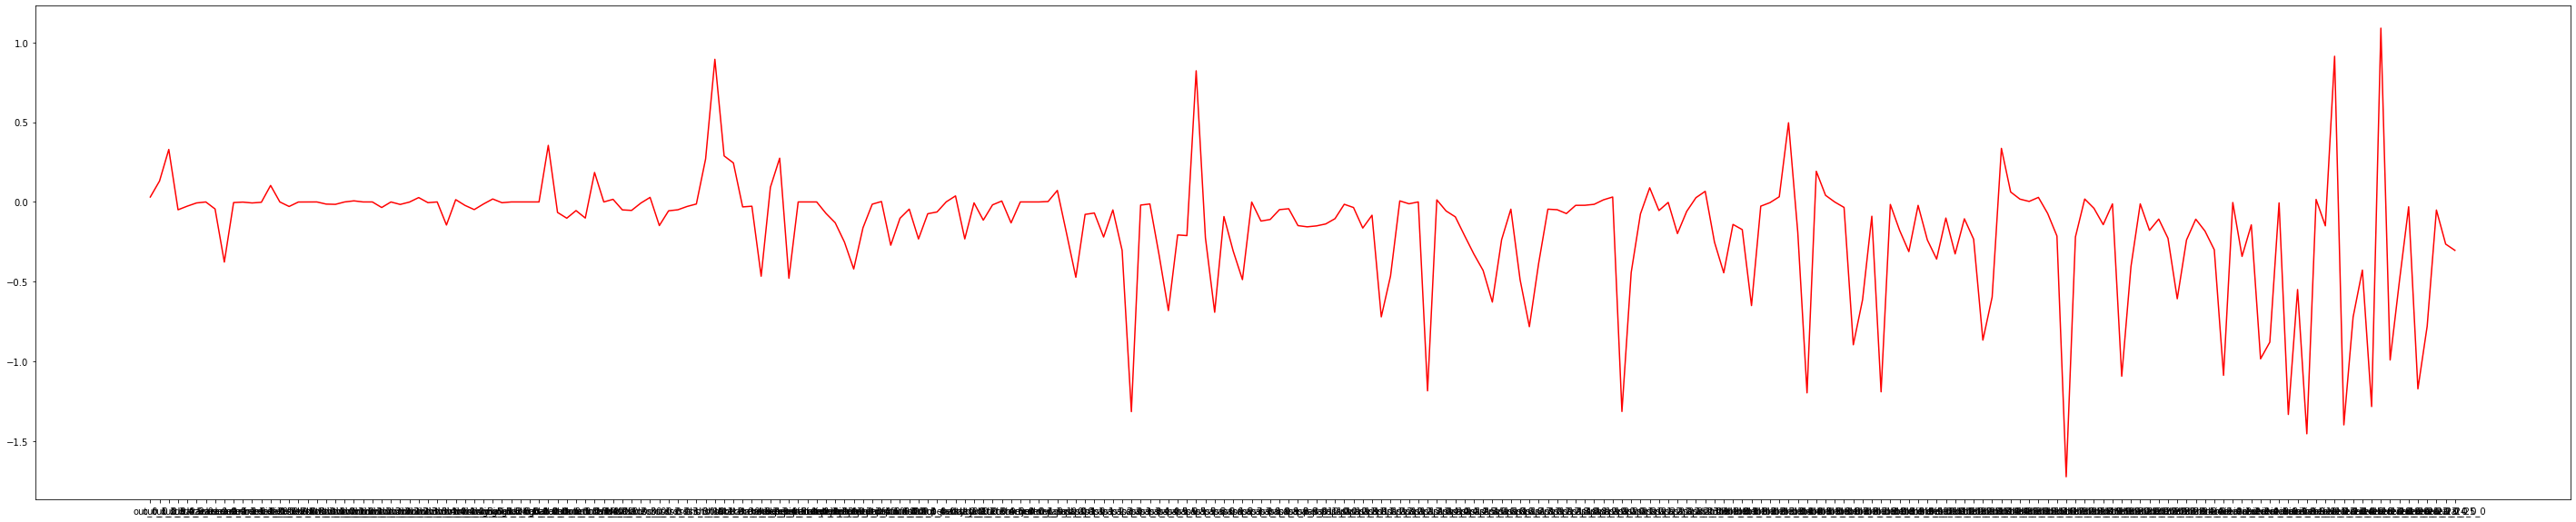

In [18]:
# Difference between Aguero and Firmino
plt.figure(figsize=(50,10))
plt.plot(vectors_pd_norm.columns.values, vectors_pd_norm.loc[3237] - vectors_pd_norm.loc[3535],'r')

out 6


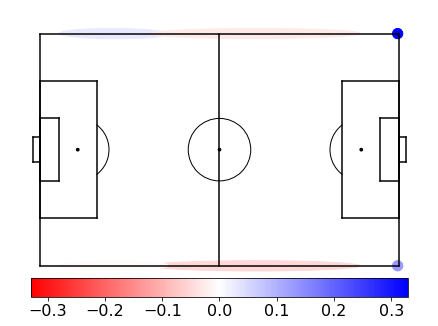

clearance 3
clearance_0 3
clearance_1 2
clearance_2 2


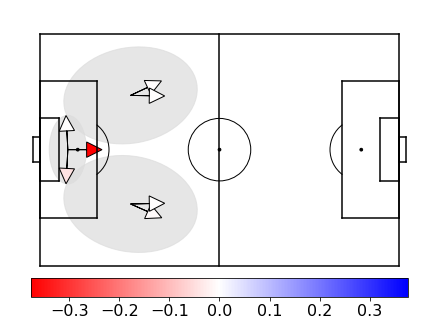

freekick 4
freekick_0 1
freekick_1 1
freekick_2 2
freekick_3 2


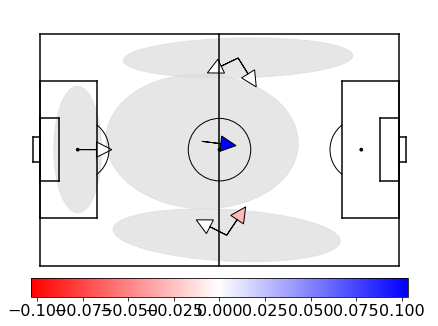

throw_in 6
throw_in_0 2
throw_in_1 4
throw_in_2 4
throw_in_3 2
throw_in_4 4
throw_in_5 4


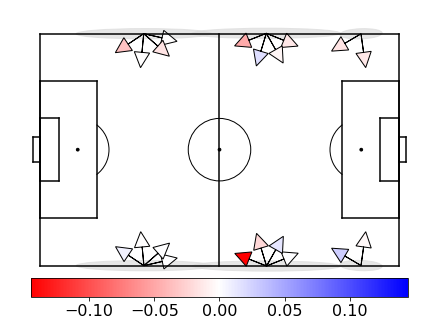

goalkick 1
goalkick_0 3


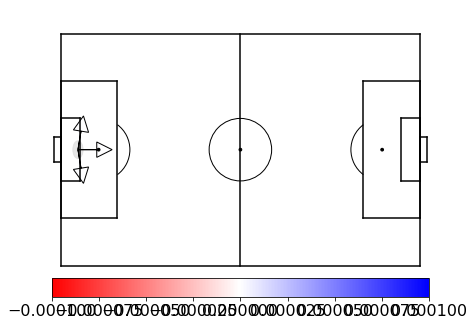

owngoal 1


../vis.py:179: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


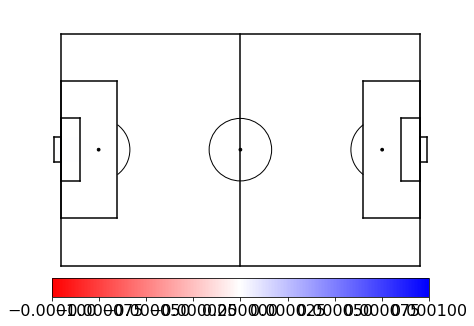

goal 1


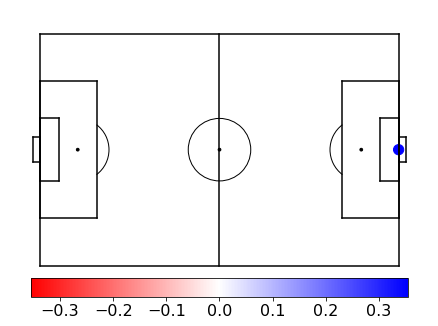

bad_touch 5


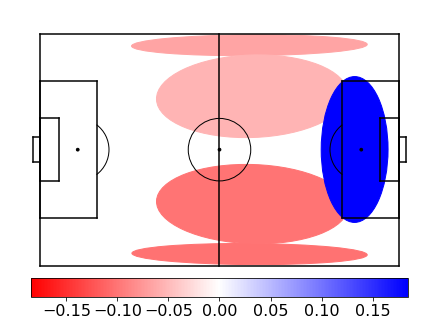

red_card 1


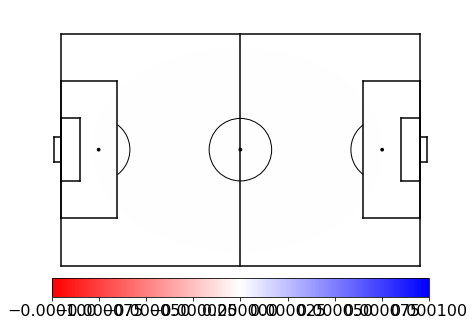

offside 4


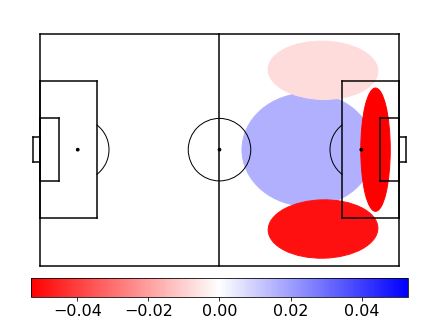

cross 4
cross_0 1
cross_1 1
cross_2 2
cross_3 2


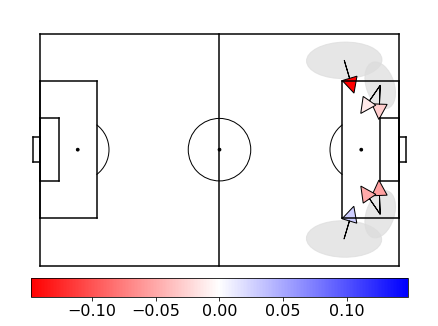

shot 3
shot_0 2
shot_1 1
shot_2 1


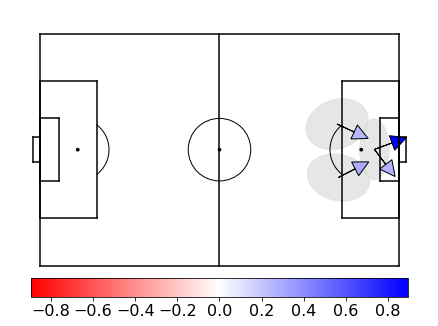

take_on 6


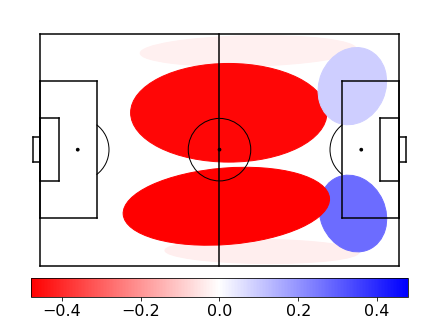

keeper_catch 3


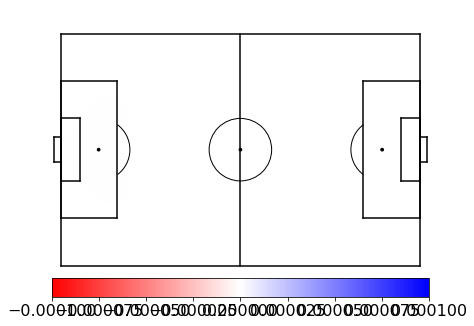

interception 8


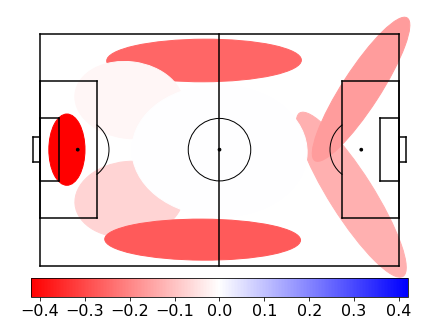

foul 5


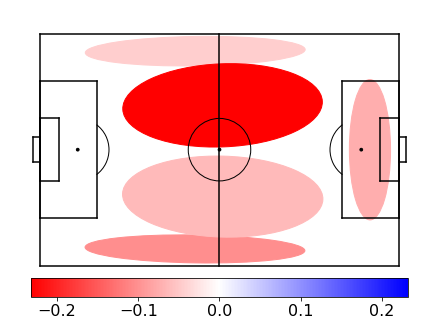

shot_penalty 1
shot_penalty_0 2


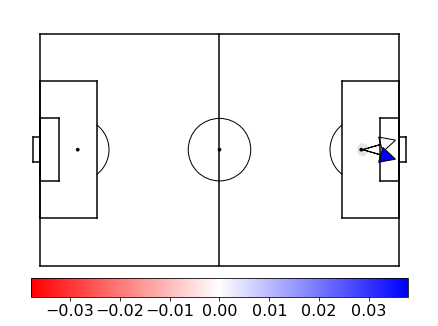

tackle 6


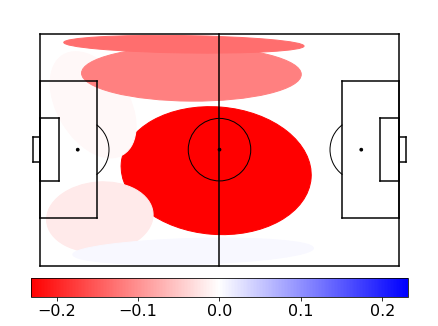

corner 2
corner_0 2
corner_1 2


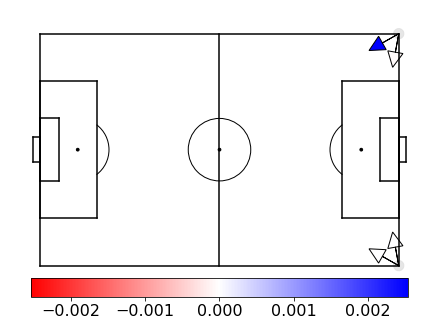

yellow_card 1


../vis.py:179: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


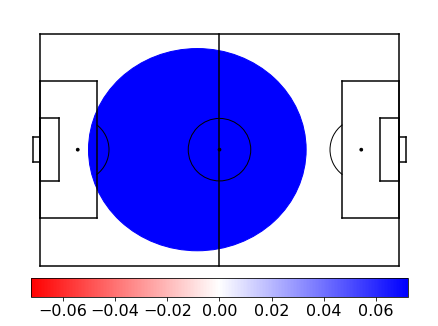

pass 24
pass_0 2
pass_1 4
pass_2 2
pass_3 2
pass_4 2
pass_5 4
pass_6 4
pass_7 2
pass_8 4
pass_9 2
pass_10 4
pass_11 4
pass_12 3
pass_13 2
pass_14 4
pass_15 2
pass_16 4
pass_17 4
pass_18 3
pass_19 2
pass_20 2
pass_21 3
pass_22 4
pass_23 2


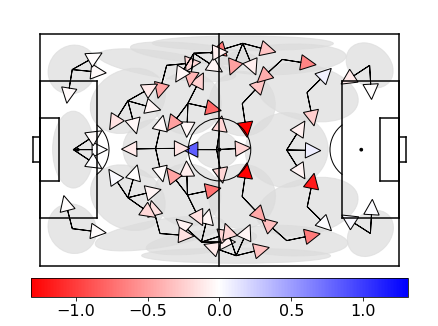

dribble 26
dribble_0 2
dribble_1 2
dribble_2 2
dribble_3 2
dribble_4 2
dribble_5 2
dribble_6 2
dribble_7 3
dribble_8 3
dribble_9 3
dribble_10 2
dribble_11 2
dribble_12 1
dribble_13 2
dribble_14 2
dribble_15 3
dribble_16 2
dribble_17 2
dribble_18 2
dribble_19 3
dribble_20 1
dribble_21 2
dribble_22 2
dribble_23 2
dribble_24 2
dribble_25 1


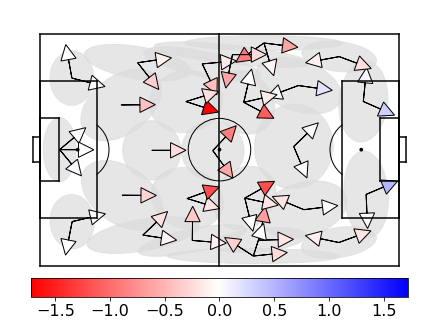

receival 26


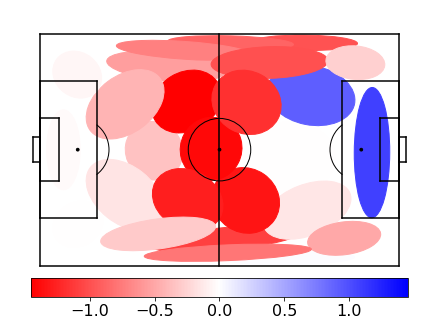

In [19]:
vis.show_component_differences(loc_models, dir_models, vectors_pd_norm.loc[3237], vectors_pd_norm.loc[3535], "Aguero", "Firmino", save=False)